# Sentiment analysis of women's clothes reviews

## Part 4: Sentiment analysis by using Glove embeddings and LSTM.

The aim of this project is sentiment analysis to determined whether the product is recommended or not based on a review as an input text. In this approach I have used a pre-trained Glove word embeddings model and Bidirectional LSTM Neural Network. 

The Bidirectional LSTMs are an extension of traditional LSTMs and used to ensure that information is passed backward and forward. They may be used on sequence classification problems. The idea of Bidirectional Recurrent Neural Networks (RNNs) is involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side. Next providing the input sequence as input to the first layer and providing a reversed copy of the input sequence to the second.

### Dataset

The dataset comes from Woman Clothing Review that can be find at Kaggle. For this project I only used two variables: Review and Recommended.

Attributes:
- Review Text - customer review body.
- Recommended IND - product customer recommendation where 1 is recommended, 0 is not recommended.

## Import libriaries and data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

First I download the pre-trained word embeddings:

In [ ]:
!wget --no-check-certificate \
    http://nlp.stanford.edu/data/glove.6B.zip \
    -O /tmp/glove.6B.zip

--2021-04-22 13:39:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-22 13:39:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-22 13:39:53--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’

/t

Next I extract them into a temporary folder:

In [ ]:
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

Loading previous cleaned dataset 'reviews_class.csv':

In [ ]:
df = pd.read_csv('reviews_class.csv', header=0,index_col=0)
df.head()

,Rating,Recommended,Review,Class
0,4,1,Absolutely wonderful - silky and sexy and comf...,Positive
1,5,1,Love this dress! it's sooo pretty. i happene...,Positive
2,3,0,I had such high hopes for this dress and reall...,Neutral
3,5,1,"I love, love, love this jumpsuit. it's fun, fl...",Positive
4,5,1,This shirt is very flattering to all due to th...,Positive


## Data preparation

Loading chosen variables: Review and Recommended.

In [ ]:
df = df[['Review', 'Recommended']]
df.head()

,Review,Recommended
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


Rename of chosen variable:

In [ ]:
text = df.rename(columns={"Recommended": "Sentiment"})
text.head()

,Review,Sentiment
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


**First observations**:

In [ ]:
text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     22641 non-null  object
 1   Sentiment  22641 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 530.6+ KB


Shape of data:

In [ ]:
text.shape

(22641, 2)

Unique values for 'Sentiment' variable:

In [ ]:
text['Sentiment'].value_counts()

1    18540
0     4101
Name: Sentiment, dtype: int64

## Text data preparation

Spliting the data into train and test sets:

In [ ]:
X = text['Review']
y = text['Sentiment']

X_train_sentences, X_test_sentences, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

#### Tokenizing the words:

Cause the data are text it has to be converted into numerical form because the deep learning model expects it. To convert sentences into numerical representations I have used `Tokenizer` which removes punctuation marks and special characters and converts the sentence to lowercase letter. 

In [ ]:
# Constants
vocab_size=5000
embedding_dim=16
max_len=100
trunction_type='post'
padding_type='post'
oov_token = "<OOV>"

In [ ]:
tokenize = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenize.fit_on_texts(X_train_sentences)

The word index show how words are mapped into numbers:

In [ ]:
word_index = tokenize.word_index

By use `texts_to_sequences` from the tokenizer I convert the words into sequences so that a complete sequence of numbers can represent every sentence. 

In [ ]:
X_train = tokenize.texts_to_sequences(X_train_sentences)
X_test = tokenize.texts_to_sequences(X_test_sentences)

In [ ]:
X_train[9:11]

[[197,
  405,
  63,
  45,
  35,
  554,
  964,
  837,
  263,
  53,
  23,
  81,
  3,
  72,
  2,
  47,
  4,
  3,
  39,
  1206],
 [79, 53]]

Now I add padding to the data by using `pad_sequences`function to make it uniform:

In [ ]:
X_train_pad = pad_sequences(X_train,maxlen=max_len, padding=padding_type, 
                            truncating=trunction_type)

X_test_pad = pad_sequences(X_test,maxlen=max_len, padding=padding_type, 
                           truncating=trunction_type)

### GloVe Embeddings

In this step I use pre-trained word embeddings to create own embedding layer. Loading the Glove embeddings and append them to a dictionary. Then I use this dictionary to create an embedding matrix for each word in the training set. 

In [ ]:
embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    try:
       coefs = np.asarray(values[1:], dtype='float32')
       embeddings_index[word] = coefs
    except ValueError:
       pass
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
num_words = len(word_index) + 1

embedding_matrix = np.zeros((num_words, max_len))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word) 
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Finally I create the embedding layer:

In [ ]:
embedding_layer = Embedding(num_words,
                            max_len,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)

## Build the model

I create a model using embedding layer and Bidirectional LSTM layers. Bidirectional LSTMs are supported in Keras via the Bidirectional layer wrapper and it takes a recurrent layer (e.g. the first LSTM layer) as an argument.

**Model 1**

In [ ]:
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(embedding_dim, return_sequences=True)), 
    Bidirectional(LSTM(embedding_dim)),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1343700   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 32)           14976     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 6)                 198       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 1,365,153
Trainable params: 21,453
Non-trainable params: 1,343,700
_________________________________________________________________


Then I train the model for 10 epoch:

In [ ]:
history = model.fit(X_train_pad, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_test_pad, y_test),
                    verbose=1)

Epoch 1/10
566/566 [==============================] - 47s 76ms/step - loss: 0.4598 - accuracy: 0.8179 - val_loss: 0.4419 - val_accuracy: 0.8075
Epoch 2/10
566/566 [==============================] - 42s 73ms/step - loss: 0.3995 - accuracy: 0.8302 - val_loss: 0.3954 - val_accuracy: 0.8337
Epoch 3/10
566/566 [==============================] - 41s 72ms/step - loss: 0.3542 - accuracy: 0.8404 - val_loss: 0.3663 - val_accuracy: 0.8267
Epoch 4/10
566/566 [==============================] - 41s 73ms/step - loss: 0.3464 - accuracy: 0.8447 - val_loss: 0.3827 - val_accuracy: 0.8064
Epoch 5/10
566/566 [==============================] - 42s 74ms/step - loss: 0.3483 - accuracy: 0.8319 - val_loss: 0.3186 - val_accuracy: 0.8613
Epoch 6/10
566/566 [==============================] - 42s 75ms/step - loss: 0.3023 - accuracy: 0.8674 - val_loss: 0.3050 - val_accuracy: 0.8649
Epoch 7/10
566/566 [==============================] - 43s 76ms/step - loss: 0.2817 - accuracy: 0.8774 - val_loss: 0.2900 - val_accuracy:

Predictions on a test set:

In [ ]:
loss, accuracy = model.evaluate(X_test_pad,y_test)
print('Test accuracy :', accuracy)

142/142 [==============================] - 3s 21ms/step - loss: 0.2843 - accuracy: 0.8803
Test accuracy : 0.8803268074989319


Visualization of training:

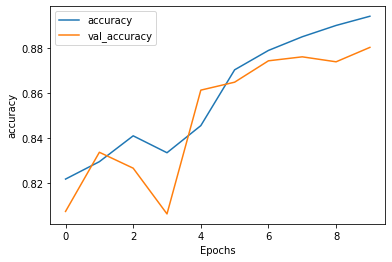

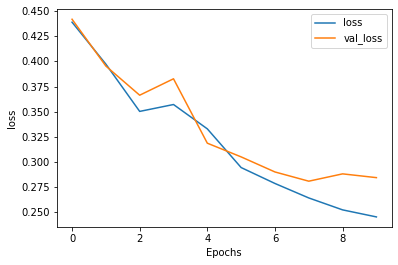

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# save the model
model.save("sentiment_model.h5")

**Model 2**

I also test a second model with a Dropout layer for decrease overfitting and increase number of epochs to 20:

In [ ]:
model2 = Sequential([
    embedding_layer,
    Bidirectional(LSTM(64, return_sequences=True)), 
    Bidirectional(LSTM(32)),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model2.compile(loss='binary_crossentropy', 
               optimizer=optimizer,
               metrics=['accuracy'])

model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1343700   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 100, 128)          84480     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_13 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 1,470,453
Trainable params: 126,753
Non-trainable params: 1,343,700
______________________________________

In [ ]:
callbacks = EarlyStopping(monitor = 'val_accuracy', 
                          mode = 'max', 
                          patience = 10,
                          verbose = 1)

In [ ]:
history2 = model2.fit(X_train_pad, y_train,
                    batch_size=32,
                    epochs=20,
                    validation_data=(X_test_pad, y_test),
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/20
566/566 [==============================] - 92s 152ms/step - loss: 0.5288 - accuracy: 0.7981 - val_loss: 0.4305 - val_accuracy: 0.8064
Epoch 2/20
566/566 [==============================] - 85s 150ms/step - loss: 0.4186 - accuracy: 0.8241 - val_loss: 0.3872 - val_accuracy: 0.8159
Epoch 3/20
566/566 [==============================] - 85s 150ms/step - loss: 0.3853 - accuracy: 0.8362 - val_loss: 0.3736 - val_accuracy: 0.8359
Epoch 4/20
566/566 [==============================] - 85s 150ms/step - loss: 0.3608 - accuracy: 0.8461 - val_loss: 0.3710 - val_accuracy: 0.8306
Epoch 5/20
566/566 [==============================] - 85s 150ms/step - loss: 0.3556 - accuracy: 0.8499 - val_loss: 0.3461 - val_accuracy: 0.8488
Epoch 6/20
566/566 [==============================] - 85s 149ms/step - loss: 0.3325 - accuracy: 0.8602 - val_loss: 0.3241 - val_accuracy: 0.8589
Epoch 7/20
566/566 [==============================] - 85s 150ms/step - loss: 0.3204 - accuracy: 0.8626 - val_loss: 0.3182 - val_ac

Predictions:

In [ ]:
loss, accuracy = model2.evaluate(X_test_pad,y_test)
print('Test accuracy :', accuracy)

142/142 [==============================] - 5s 37ms/step - loss: 0.2887 - accuracy: 0.8752
Test accuracy : 0.875248372554779


Visualization of training:

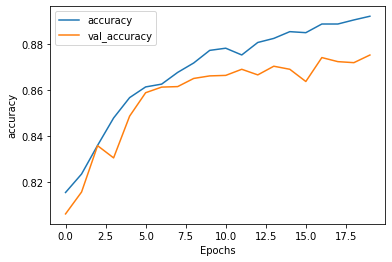

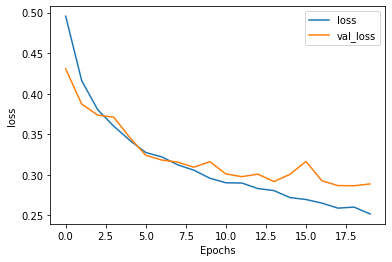

In [ ]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

## Summary

In this project I have used a pre-trained Glove word embeddings with Bidirectional LSTM Neural Network to resolve classification problem. After trained two models I have achieved an accuracy on the test set 88 % and it is a good result in comparison to previous Machine Learning models that I have used (e.g. Logistic Regression, Random Forest).